# Near-Deterministic Rule Mining and Anomaly Detection in Clinical Data

This notebook contains the complete implementation and usage example of the **HierarchicalRulesExplorer** class for near-deterministic association rule discovery and anomaly detection in structured data (e.g., clinical data).

The approach combines data discretization, frequent itemset mining (using the Apriori algorithm), and rule filtering to extract highly reliable association rules. These rules can then be used to assess new data for compliance or potential anomalies.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# Import tqdm for progress bars.
from tqdm import tqdm

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from pandas.plotting import parallel_coordinates
import networkx as nx



In [44]:
class HierarchicalRulesExplorer:
    """
    A class for discovering near-deterministic (almost deterministic) association rules 
    in a DataFrame and checking the compliance of new data against these rules.
    
    Key features:
      - Discretization of continuous variables with custom binning options.
      - Extraction and filtering of association rules based on support, confidence, lift, and conviction.
      - Methods to summarize, visualize, deduplicate the rules, and evaluate data compliance.
      - Enhanced anomaly detection and compliance summary reporting.
      - Supports optional sampling and train/validation/test splits.
      - Designed for modularity and future GUI integration.
    """

    def __init__(self, 
                 min_support=0.01, 
                 min_confidence=0.98, 
                 min_lift=1.0, 
                 min_conviction=0.0,
                 min_rule_support=None,
                 deterministic_only=False,
                 discretization_bins=5,
                 bin_edges=None,
                 skip_discretization=None,
                 min_itemset_length=2,
                 max_itemset_length=3,
                 sample_fraction=None,    # Optional: fraction of data to sample (0 < sample_fraction <= 1)
                 display_plots=True,      # Flag to display plots (useful for GUI integration)
                 verbose=True):           # Flag to control printing/logging messages
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.min_lift = min_lift
        self.min_conviction = min_conviction
        self.min_rule_support = min_rule_support if min_rule_support is not None else min_support
        self.deterministic_only = deterministic_only
        
        self.discretization_bins = discretization_bins
        self.bin_edges = bin_edges if bin_edges is not None else {}
        self.skip_discretization = skip_discretization if skip_discretization is not None else []
        
        self.min_itemset_length = min_itemset_length
        self.max_itemset_length = max_itemset_length

        # New parameters for scalability and interface
        self.sample_fraction = sample_fraction
        self.display_plots = display_plots
        self.verbose = verbose
        
        # Internal storage for discovered rules and binning information
        self.rules_ = None
        self._trained_bin_info = {}

    def _progress(self, iterable, desc="", total=None):
        """
        Helper method to wrap an iterable with a progress bar if verbose is True.
        
        Args:
            iterable: An iterable to be wrapped.
            desc (str): Description for the progress bar.
            total (int, optional): Total number of items, if known.
        
        Returns:
            iterable: A tqdm-wrapped iterator if verbose is True, else the original iterable.
        """
        if self.verbose:
            return tqdm(iterable, desc=desc, total=total)
        else:
            return iterable

    def fit(self, df):
        """
        Learn near-deterministic association rules from the given DataFrame.
        
        The process includes:
          1) (Optional) Sampling the data for scalability.
          2) Discretizing continuous columns.
          3) Converting each row to a transaction of 'column=value' strings.
          4) One-hot encoding and mining frequent itemsets using Apriori.
          5) Generating and filtering association rules.
          6) Visualizing initial and filtered rule metrics.
          7) Reducing redundancy by filtering and deduplicating the rules.
          8) (Optionally) Plotting parallel coordinates for the final rule set.
          
        Returns:
            self : object
        """
        # Optional sampling for large datasets
        if self.sample_fraction is not None and 0 < self.sample_fraction < 1:
            if self.verbose:
                print(f"Sampling data: Using {self.sample_fraction * 100:.1f}% of the input data.")
            df = df.sample(frac=self.sample_fraction, random_state=42)
        
        # 1) Discretize continuous columns using training data (fit=True)
        df_discretized = self._discretize_continuous_columns(df.copy(), fit=True)
        
        # 2) Convert each row to a transaction of 'column=value' strings.
        transactions = self._make_transactions(df_discretized)
        
        # 3) One-hot encode the transactions for frequent pattern mining.
        te = TransactionEncoder()
        te_array = te.fit(transactions).transform(transactions)
        onehot_df = pd.DataFrame(te_array, columns=te.columns_)
        
        # 4) Discover frequent itemsets using Apriori.
        itemsets = apriori(
            onehot_df, 
            min_support=self.min_support, 
            use_colnames=True, 
            max_len=self.max_itemset_length
        )
        
        if itemsets.empty:
            warnings.warn("No frequent itemsets found with the specified min_support. "
                          "Consider lowering the min_support threshold.")
            self.rules_ = pd.DataFrame()
            return self

        # Filter itemsets by the minimum length requirement.
        itemsets['length'] = itemsets['itemsets'].apply(len)
        itemsets = itemsets[itemsets['length'] >= self.min_itemset_length].reset_index(drop=True)
        if itemsets.empty:
            warnings.warn("All frequent itemsets are below the min_itemset_length.")
            self.rules_ = pd.DataFrame()
            return self

        # 5) Generate association rules from the frequent itemsets.
        rules = association_rules(
            itemsets, 
            metric="confidence", 
            min_threshold=self.min_confidence
        )
        
        # Initial scatterplot of support vs. confidence (unfiltered rules).
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x="support", y="confidence", data=rules)
        plt.margins(0.01, 0.01)
        plt.title("Initial Scatterplot: Support vs Confidence")
        if self.display_plots:
            plt.show()
        else:
            plt.close()
        
        # Keep only rules with exactly one item in the consequent.
        rules = rules[rules['consequents'].apply(lambda x: len(x) == 1)]
        
        # Filter rules by lift, conviction, and rule support.
        rules = rules[(rules['lift'] >= self.min_lift) &
                      (rules['conviction'] >= self.min_conviction) &
                      (rules['support'] >= self.min_rule_support)]
        
        
        # Add a unique rule identifier column for later reference.
        rules = rules.reset_index(drop=True)
        rules['rule_id'] = rules.index

        if rules.empty:
            warnings.warn("No association rules were discovered after applying all thresholds. "
                          "Consider adjusting your parameters.")
            self.rules_ = pd.DataFrame()
            return self

        # Compute an additional 'certainty' column (certainty = 2 * confidence - 1).
        rules['certainty'] = 2 * rules['confidence'] - 1

        # If only deterministic (certainty==1) rules are desired, filter them.
        if self.deterministic_only:
            tol = 1e-6  # tolerance for floating point comparisons.
            rules = rules[rules['confidence'] >= 1.0 - tol]
            if rules.empty:
                warnings.warn("No deterministic rules (confidence==1) were found with the current thresholds.")
        
        # Sort rules by confidence and support in descending order.
        rules = rules.sort_values(by=['confidence', 'support'], ascending=False).reset_index(drop=True)
        self.rules_ = rules
        
        # Scatterplot colored by consequent (filtered rules).
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x="support", y="confidence", hue="consequents", data=rules)
        plt.margins(0.01, 0.01)
        plt.title("Filtered Rules: Support vs Confidence (by Consequent)")
        if self.display_plots:
            plt.show()
        else:
            plt.close()

        # 6) Reduce redundancy: filter maximal rules and deduplicate.
        self.filter_maximal_rules()
        self.unique_rules()

        # 7) Plot parallel coordinates for the final rule set.
        #self._plot_parallel_coordinates(self.rules_)
        
        return self

    def filter_maximal_rules(self):
        """
        For rules sharing the same consequent, keep only those with the largest antecedent set.
        This helps remove redundant rules.
        """
        if self.rules_ is None or self.rules_.empty:
            warnings.warn("No rules available to filter. Ensure the model is fitted first.")
            return self.rules_

        filtered_groups = []
        # Convert groupby iterator to a list to support progress display.
        groups = list(self.rules_.groupby('consequents'))
        for cons, group in self._progress(groups, desc="Filtering maximal rules", total=len(groups)):
            group = group.copy()
            indices_to_drop = set()
            for i in group.index:
                antecedents_i = group.loc[i, 'antecedents']
                for j in group.index:
                    if i == j:
                        continue
                    antecedents_j = group.loc[j, 'antecedents']
                    # If rule i is a proper subset of rule j, mark it for removal.
                    if antecedents_i.issubset(antecedents_j) and antecedents_i != antecedents_j:
                        indices_to_drop.add(i)
                        break
            filtered_group = group.drop(index=indices_to_drop)
            filtered_groups.append(filtered_group)

        self.rules_ = pd.concat(filtered_groups).reset_index(drop=True)
        return self.rules_

    def unique_rules(self):
        """
        Deduplicate rules by ensuring the union of antecedents and consequents is unique.
        """
        if self.rules_ is None or self.rules_.empty:
            warnings.warn("No rules available to process. Ensure the model is fitted first.")
            return self.rules_
        
        self.rules_['rule_itemset'] = self.rules_.apply(
            lambda row: frozenset(row['antecedents'].union(row['consequents'])), axis=1
        )
        self.rules_ = self.rules_.drop_duplicates(subset='rule_itemset')\
                                   .drop(columns=['rule_itemset'])\
                                   .reset_index(drop=True)
        return self.rules_

    def check_consistency(self, df_test):
        """
        Check whether new data violates any of the learned near-deterministic rules.
        
        Returns:
            A list of dictionaries, each containing details about a rule violation:
                - 'row_index': index of the row in the input DataFrame.
                - 'rule_id': identifier of the violated rule.
                - 'antecedents': set of antecedents for the rule.
                - 'consequents': set of consequents for the rule.
                - 'message': description of the violation.
        """
        if self.rules_ is None or self.rules_.empty:
            raise ValueError("No rules found. Ensure the model is fitted on training data first.")
        
        df_discretized = self._discretize_continuous_columns(df_test.copy(), fit=False)
        transactions = self._make_transactions(df_discretized)
        
        inconsistencies = []
        for row_index, itemset in enumerate(self._progress(transactions, desc="Checking rule consistency", total=len(transactions))):
            itemset_set = set(itemset)
            for _, rule in self.rules_.iterrows():
                antecedents = set(rule['antecedents'])
                consequents = set(rule['consequents'])
                if antecedents.issubset(itemset_set) and not consequents.issubset(itemset_set):
                    inconsistencies.append({
                        'row_index': row_index,
                        'rule_id': rule['rule_id'],
                        'antecedents': antecedents,
                        'consequents': consequents,
                        'message': 'Violated near-deterministic rule'
                    })
        return inconsistencies

    def check_compliance(self, df_test):
        """
        Check compliance of new data against the learned rules and return a new DataFrame with:
          - 'compliant': True if no rule is violated; False otherwise.
          - 'violated_rules': A list describing the violated rules.
        
        This method is the backbone for both compliance evaluation and anomaly detection.
        """
        if self.rules_ is None or self.rules_.empty:
            raise ValueError("No rules found. Ensure the model is fitted on training data first.")
        
        df_discretized = self._discretize_continuous_columns(df_test.copy(), fit=False)
        transactions = self._make_transactions(df_discretized)
        
        compliance_flags = []
        violation_details = []
        
        for row_index, itemset in enumerate(self._progress(transactions, desc="Checking compliance", total=len(transactions))):
            itemset_set = set(itemset)
            violations = []
            for _, rule in self.rules_.iterrows():
                antecedents = set(rule['antecedents'])
                consequents = set(rule['consequents'])
                if antecedents.issubset(itemset_set) and not consequents.issubset(itemset_set):
                    rule_summary = (f"Rule {rule['rule_id']}: "
                                    f"IF {','.join(sorted(list(antecedents)))} THEN {','.join(sorted(list(consequents)))}")
                    violations.append(rule_summary)
            compliance_flags.append(len(violations) == 0)
            violation_details.append(violations)
        
        # Append compliance columns to a copy of the input DataFrame.
        df_compliance = df_test.copy()
        df_compliance['compliant'] = compliance_flags
        df_compliance['violated_rules'] = violation_details
        
        return df_compliance

    def evaluate_data(self, df, split_name='Test'):
        """
        Evaluate the provided DataFrame against the learned rules.
        
        This method returns both:
          - A DataFrame with compliance annotations.
          - A summary dictionary with key metrics:
              - total_records: Total number of rows evaluated.
              - compliant_count: Number of rows compliant with all rules.
              - anomaly_count: Number of rows with one or more violations.
              - compliance_rate: Proportion of compliant records.
              - avg_violations: Average number of violated rules per record.
        
        Args:
            df (pd.DataFrame): Data to evaluate.
            split_name (str): A label for the data split (e.g., 'Train', 'Validation', 'Test').
            
        Returns:
            tuple: (df_compliance, summary_stats)
        """
        df_compliance = self.check_compliance(df)
        total_records = len(df_compliance)
        compliant_count = df_compliance['compliant'].sum()
        anomaly_count = total_records - compliant_count
        avg_violations = df_compliance['violated_rules'].apply(lambda x: len(x)).mean()
        compliance_rate = compliant_count / total_records if total_records > 0 else 0

        summary_stats = {
            'total_records': total_records,
            'compliant_count': compliant_count,
            'anomaly_count': anomaly_count,
            'compliance_rate': compliance_rate,
            'avg_violations': avg_violations
        }

        if self.verbose:
            print(f"\n{split_name} Split Evaluation Summary:")
            print(summary_stats)

        return df_compliance, summary_stats

    def fit_with_validation(self, df_train, df_validation):
        """
        Fit the model on the training data and evaluate both training and validation sets.
        
        This method:
          1. Fits the rules using the training data.
          2. Evaluates compliance on both the training and validation datasets.
          
        Returns:
            dict: A dictionary with keys 'train' and 'validation', each mapping to a tuple:
                  (compliance_dataframe, summary_statistics)
        """
        self.fit(df_train)
        train_eval = self.evaluate_data(df_train, split_name='Train')
        val_eval = self.evaluate_data(df_validation, split_name='Validation')
        return {'train': train_eval, 'validation': val_eval}

    def detect_anomalies(self, df):
        """
        Detect and return only the non-compliant (anomalous) records from the provided DataFrame.
        
        Args:
            df (pd.DataFrame): The data to evaluate.
        
        Returns:
            pd.DataFrame: Subset of the data that violates one or more rules.
        """
        df_compliance, _ = self.evaluate_data(df, split_name='Anomaly Detection')
        anomalies = df_compliance[~df_compliance['compliant']]
        if self.verbose:
            print(f"Detected {len(anomalies)} anomalies out of {len(df_compliance)} records.")
        return anomalies

    def summarize_rules(self, top_n=10, sort_by='confidence'):
        """
        Print a summary of the top association rules.
        
        Args:
            top_n (int): Number of top rules to display.
            sort_by (str): Column name to sort the rules (default 'confidence').
        
        Returns:
            pd.DataFrame: A DataFrame containing the summarized rules.
        """
        if self.rules_ is None or self.rules_.empty:
            print("No rules to summarize. Fit the model first.")
            return None
        
        if sort_by not in self.rules_.columns:
            warnings.warn(f"Invalid sort criterion '{sort_by}'. Using 'confidence' by default.")
            sort_by = 'confidence'
        
        sorted_rules = self.rules_.sort_values(by=sort_by, ascending=False).head(top_n).copy()
        sorted_rules['antecedents'] = sorted_rules['antecedents'].apply(lambda x: ','.join(sorted(list(x))))
        sorted_rules['consequents'] = sorted_rules['consequents'].apply(lambda x: ','.join(sorted(list(x))))
        
        cols_to_display = ['rule_id', 'antecedents', 'consequents', 'support', 'confidence', 'lift', 'conviction', 'certainty']
        if self.verbose:
            print("\nTop Association Rules:")
            print(sorted_rules[cols_to_display])
        return sorted_rules

    def get_rules_summary_statistics(self):
        """
        Returns summary statistics (mean, median, std) for rule metrics.
        
        Returns:
            pd.DataFrame: Summary statistics for the metrics.
        """
        if self.rules_ is None or self.rules_.empty:
            print("No rules available to summarize. Fit the model first.")
            return pd.DataFrame()
        
        metrics = ['support', 'confidence', 'lift', 'conviction', 'certainty']
        stats = {}
        for metric in metrics:
            stats[metric] = {
                'mean': self.rules_[metric].mean(),
                'median': self.rules_[metric].median(),
                'std': self.rules_[metric].std()
            }
        stats_df = pd.DataFrame(stats).T
        if self.verbose:
            print("\nRule Metrics Summary Statistics:")
            print(stats_df)
        return stats_df

    def plot_rule_metric_distribution(self, metric='confidence', bins=10):
        """
        Plot the distribution of a specified metric among the discovered rules.
        
        Args:
            metric (str): The metric to plot.
            bins (int): Number of bins for the histogram.
        """
        if self.rules_ is None or self.rules_.empty:
            print("No rules to plot. Fit the model first.")
            return
        
        if metric not in self.rules_.columns:
            print(f"Metric '{metric}' not found in rules. Available columns: {self.rules_.columns.tolist()}")
            return
        
        values = self.rules_[metric].dropna()
        plt.figure(figsize=(6, 4))
        plt.hist(values, bins=bins, edgecolor='k', color='skyblue')
        plt.title(f'Distribution of {metric.capitalize()} Among Discovered Rules')
        plt.xlabel(metric.capitalize())
        plt.ylabel("Frequency")
        plt.grid(True, linestyle='--', alpha=0.7)
        if self.display_plots:
            plt.show()
        else:
            plt.close()

    def plot_rules_bar_by_consequent(self):
        """
        Plot a bar chart of the count of discovered rules for each consequent.
        """
        if self.rules_ is None or self.rules_.empty:
            print("No rules available to plot. Fit the model first.")
            return
        
        # Create a DataFrame with consequents as string values.
        df_rules = self.rules_.copy()
        df_rules['consequent_str'] = df_rules['consequents'].apply(lambda x: ','.join(sorted(list(x))))
        counts = df_rules['consequent_str'].value_counts()
        
        plt.figure(figsize=(8, 4))
        sns.barplot(x=counts.index, y=counts.values, palette="viridis")
        plt.title("Count of Rules per Consequent")
        plt.xlabel("Consequent")
        plt.ylabel("Number of Rules")
        plt.xticks(rotation=45)
        plt.tight_layout()
        if self.display_plots:
            plt.show()
        else:
            plt.close()

    def get_rules(self):
        """
        Returns the discovered association rules as a DataFrame.
        """
        if self.rules_ is not None:
            return self.rules_
        else:
            print("No rules available. Ensure you have called 'fit' first.")
            return pd.DataFrame()

    # ------------------------ Internal Helper Methods ------------------------

    def _make_transactions(self, df_discretized):
        """
        Convert each row in the discretized DataFrame to a list of "column=value" strings.
        
        Args:
            df_discretized (pd.DataFrame): The discretized data.
        
        Returns:
            list: A list of transactions (each transaction is a list of strings).
        """
        transactions = []
        # Use progress bar for converting rows to transactions.
        for _, row in self._progress(df_discretized.iterrows(), 
                                     desc="Converting rows to transactions", 
                                     total=len(df_discretized)):
            items = []
            for col in df_discretized.columns:
                val = row[col]
                if pd.isna(val):
                    items.append(f"{col}=MISSING")
                else:
                    items.append(f"{col}={val}")
            transactions.append(items)
        return transactions

    def _discretize_continuous_columns(self, df, fit=False):
        """
        Discretize numeric columns using custom bin edges or equal-width binning.
        Columns listed in skip_discretization are left unchanged.
        
        Args:
            df (pd.DataFrame): The input DataFrame.
            fit (bool): If True, learn the binning edges; otherwise, use the trained edges.
            
        Returns:
            pd.DataFrame: The DataFrame with discretized numeric columns.
        """
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        # Wrap the loop over numeric columns with a progress bar.
        for col in self._progress(numeric_cols, desc="Discretizing numeric columns", total=len(numeric_cols)):
            # Convert to object to allow "MISSING" string values.
            df[col] = df[col].astype(object)
            df.loc[df[col].isna(), col] = "MISSING"
            if (col in self.skip_discretization) or all(df[col] == "MISSING"):
                continue

            if col in self.bin_edges:
                edges = self.bin_edges[col]
                labels = [f"{col}_bin{i}" for i in range(len(edges) - 1)]
                if fit:
                    self._trained_bin_info[col] = (edges, labels)
                else:
                    edges, labels = self._trained_bin_info[col]
                mask = (df[col] != "MISSING")
                df.loc[mask, col] = pd.cut(
                    df.loc[mask, col].astype(float),
                    bins=edges,
                    labels=labels,
                    include_lowest=True
                )
            else:
                if fit:
                    temp_series = df.loc[df[col] != "MISSING", col].astype(float)
                    min_val, max_val = temp_series.min(), temp_series.max()
                    # Handle the case where all values are equal.
                    if min_val == max_val:
                        edges = [min_val, min_val + 1e-9] 
                    else:
                        edges = np.linspace(min_val, max_val, self.discretization_bins + 1)
                    labels = [f"{col}_bin{i}" for i in range(len(edges) - 1)]
                    self._trained_bin_info[col] = (edges, labels)
                else:
                    edges, labels = self._trained_bin_info[col]
                mask = (df[col] != "MISSING")
                df.loc[mask, col] = pd.cut(
                    df.loc[mask, col].astype(float),
                    bins=edges,
                    labels=labels,
                    include_lowest=True
                )
        return df

    def _plot_parallel_coordinates(self, rules_df):
        """
        Private method to plot parallel coordinates for the final set of rules.
        
        Args:
            rules_df (pd.DataFrame): DataFrame containing the final set of rules.
        """
        if rules_df.empty:
            warnings.warn("No rules available for parallel coordinates plot.")
            return
        
        # Build a small DataFrame with 'rule_id', 'antecedent', and 'consequent' columns.
        pc_data = rules_df[['rule_id', 'antecedents', 'consequents']].copy()
        
        # Convert sets to comma-delimited strings for plotting.
        pc_data['antecedent'] = pc_data['antecedents'].apply(lambda x: ','.join(sorted(list(x))))
        pc_data['consequent'] = pc_data['consequents'].apply(lambda x: ','.join(sorted(list(x))))
        
        # The parallel_coordinates function requires numeric dimensions; convert categorical labels to codes.
        pc_data['antecedent_code'] = pc_data['antecedent'].astype('category').cat.codes
        pc_data['consequent_code'] = pc_data['consequent'].astype('category').cat.codes
        
        # Rename 'rule_id' to 'class' for grouping in the plot.
        pc_data.rename(columns={'rule_id': 'class'}, inplace=True)
        
        plt.figure(figsize=(5, 8))
        parallel_coordinates(pc_data[['class', 'antecedent_code', 'consequent_code']], 'class', 
                             color=sns.color_palette("Spectral", len(pc_data)))
        plt.title("Parallel Coordinates: Final Filtered Rules")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xlabel("Features (Antecedent / Consequent Code)")
        plt.ylabel("Category Code")
        plt.legend([], fontsize=8)
        plt.tight_layout()
        if self.display_plots:
            plt.show()
        else:
            plt.close()

def plot_rules_network(self, top_n=4, support_threshold=0.05, certainty_threshold=0.98):
    """
    Plot a network graph of the top association rules based on high support and near-certain confidence.
    
    This method filters the discovered rules to include only those with support above 
    `support_threshold` and confidence above `certainty_threshold`. It then selects the top_n rules 
    (sorted by support and confidence) and builds a directed graph where:
      - Nodes represent individual items (from either antecedents or consequents).
      - Directed edges represent the rule from each antecedent to each consequent.
      - Edge labels include the rule's support and confidence.
    
    Args:
        top_n (int): Maximum number of rules to display.
        support_threshold (float): Minimum support required for a rule to be considered.
        certainty_threshold (float): Minimum confidence (e.g., 0.98 for near-certain) required.
    
    Returns:
        None
    """
    # Ensure that rules have been learned
    if self.rules_ is None or self.rules_.empty:
        print("No rules available to plot. Ensure the model is fitted first.")
        return

    # Filter rules based on specified support and confidence thresholds.
    filtered_rules = self.rules_[
        (self.rules_['support'] >= support_threshold) & 
        (self.rules_['confidence'] >= certainty_threshold)
    ]
    
    if filtered_rules.empty:
        print("No rules meet the specified support and confidence thresholds.")
        return

    # Sort rules by support and confidence (in descending order) and select the top_n rules.
    filtered_rules = filtered_rules.sort_values(
        by=['support', 'confidence'], ascending=False
    ).head(top_n)
    
    # Initialize a directed graph.
    G = nx.DiGraph()
    
    # Iterate over the filtered rules to add nodes and directed edges.
    for _, rule in filtered_rules.iterrows():
        # Convert antecedents and consequents from sets/frozensets to sorted lists.
        antecedents = sorted(rule['antecedents'])
        consequents = sorted(rule['consequents'])
        
        # Add nodes for each item.
        for item in antecedents:
            G.add_node(item, role='antecedent')
        for item in consequents:
            G.add_node(item, role='consequent')
        
        # Create directed edges from each antecedent to each consequent.
        for a in antecedents:
            for c in consequents:
                # Attach support and confidence as edge attributes.
                G.add_edge(a, c, support=rule['support'], confidence=rule['confidence'])
    
    # Use a spring layout for the graph.
    pos = nx.spring_layout(G, seed=42)  # Seed ensures reproducible layout.
    
    # Plot the graph.
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=1500)
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    # Create and draw edge labels with support and confidence values.
    edge_labels = {
        (u, v): f"s: {d['support']:.2f}\nc: {d['confidence']:.2f}" 
        for u, v, d in G.edges(data=True)
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)
    
    plt.title("Network Plot of Top Association Rules")
    plt.axis('off')
    plt.tight_layout()
    if self.display_plots:
        plt.show()
    else:
        plt.close()

# Attach the new method to the HierarchicalRulesExplorer class.
HierarchicalRulesExplorer.plot_rules_network = plot_rules_network


## Extended Discussion

The **HierarchicalRulesExplorer** class implements a robust pipeline for association rule mining, with a focus on extracting near-deterministic rules that are particularly useful in domains such as clinical data analysis. Here are some key points and motivations behind the design:

- **Data Sampling and Preprocessing:**
  - To handle large datasets, an optional sampling mechanism is available. This ensures that the mining process remains computationally feasible while still capturing the essential patterns.
  - Continuous variables are discretized into bins. This step is crucial because many association rule algorithms (such as Apriori) work with categorical data. The option to provide custom bin edges or to use equal-width binning adds flexibility.

- **Transaction Encoding:**
  - Each row in the dataset is converted into a transaction—a list of strings in the form `column=value`. This transformation enables the one-hot encoding process that is required for frequent itemset mining.

- **Frequent Itemset Mining and Rule Generation:**
  - The Apriori algorithm is employed to extract frequent itemsets based on a minimum support threshold. This is followed by the generation of association rules that satisfy a high confidence level.
  - Additional rule metrics such as lift, conviction, and a computed 'certainty' (defined as \(2 \times \text{confidence} - 1\)) help in filtering out the most reliable rules.

- **Rule Filtering and Deduplication:**
  - To reduce redundancy, the notebook implements a two-step approach:
    - **Maximal Rule Filtering:** For each consequent, only rules with the largest antecedent sets are kept.
    - **Deduplication:** Rules are further deduplicated by ensuring that the union of antecedents and consequents is unique.

- **Compliance Checking and Anomaly Detection:**
  - The learned rules are then used to assess new data. Any record that violates one or more rules is flagged as anomalous. This mechanism can be used for quality control in data streams or as an early-warning system in clinical applications.

This modular design allows for easy integration into larger systems, including potential GUI applications, and offers clear summaries and visualizations at multiple stages of the pipeline.

/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_56350/127755155.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


['race', 'gender', 'age', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']
Sampling data: Using 80.0% of the input data.


Converting rows to transactions: 100%|██████████| 4000/4000 [00:00<00:00, 12851.69it/s]
/Users/denizakdemir/Dropbox/dakdemirGithub/denizakdemir.github.io/.venv/lib/python3.10/site-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


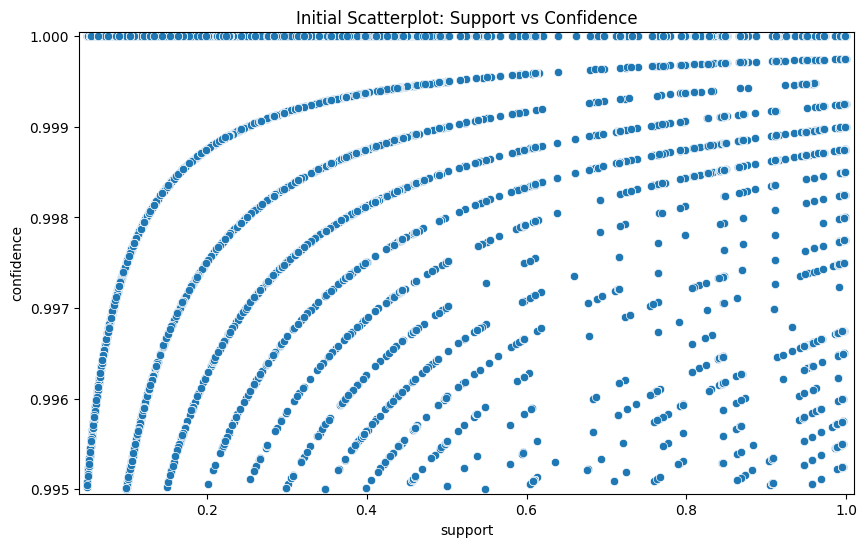

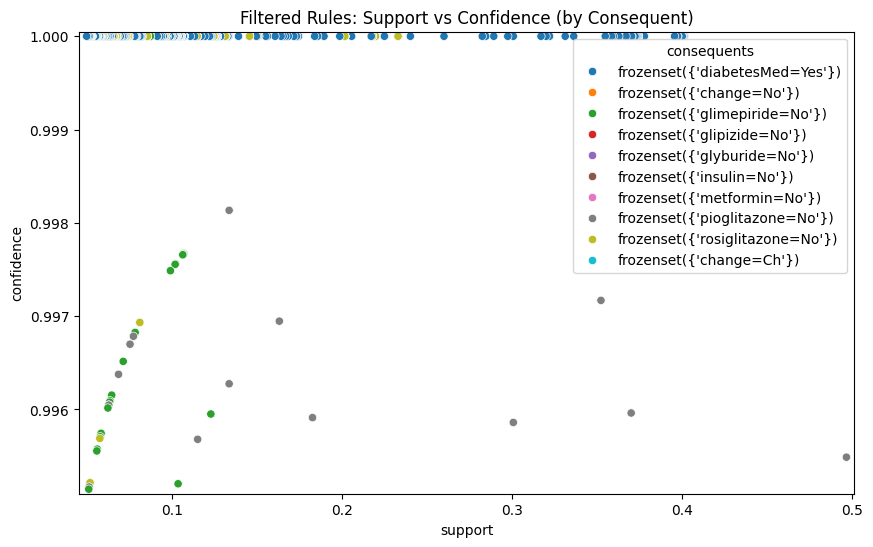

Checking compliance: 100%|██████████| 5000/5000 [01:04<00:00, 77.06it/s]



Train Split Evaluation Summary:
{'total_records': 5000, 'compliant_count': np.int64(4961), 'anomaly_count': np.int64(39), 'compliance_rate': np.float64(0.9922), 'avg_violations': np.float64(0.0296)}


Checking compliance: 100%|██████████| 250/250 [00:03<00:00, 78.26it/s]


Validation Split Evaluation Summary:
{'total_records': 250, 'compliant_count': np.int64(248), 'anomaly_count': np.int64(2), 'compliance_rate': np.float64(0.992), 'avg_violations': np.float64(0.008)}

Top Association Rules:
     rule_id                                        antecedents  \
0         57                         acetohexamide=No,change=Ch   
491       86                         age=[70-80),diabetesMed=No   
483      317                         diabetesMed=No,gender=Male   
484      433  diabetesMed=No,number_diagnoses=number_diagnos...   
485      441                      diabetesMed=No,readmitted=>30   
486      427  diabetesMed=No,num_lab_procedures=num_lab_proc...   
487      430  diabetesMed=No,num_medications=num_medications...   
488      447  diabetesMed=No,time_in_hospital=time_in_hospit...   
489      432  diabetesMed=No,number_diagnoses=number_diagnos...   
490      420           diabetesMed=No,medical_specialty=MISSING   

         consequents  support  confide


/Users/denizakdemir/Dropbox/dakdemirGithub/denizakdemir.github.io/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


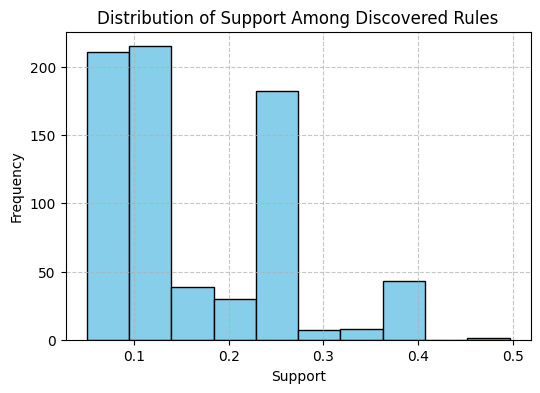

/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_56350/801384969.py:483: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


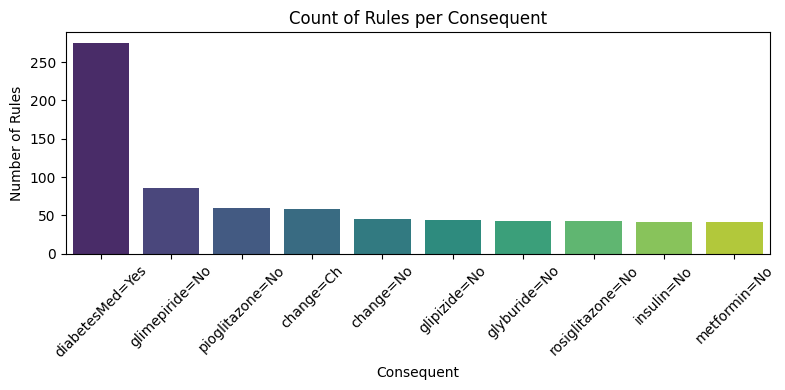

Checking compliance: 100%|██████████| 5/5 [00:00<00:00, 70.05it/s]



Test Split Evaluation Summary:
{'total_records': 5, 'compliant_count': np.int64(5), 'anomaly_count': np.int64(0), 'compliance_rate': np.float64(1.0), 'avg_violations': np.float64(0.0)}

Compliance DataFrame (first 5 rows):
      compliant violated_rules
5250       True             []
5251       True             []
5252       True             []
5253       True             []
5254       True             []

Sample of Filtered Rules:
                                           antecedents        consequents  \
0                       (change=Ch, acetohexamide=No)  (diabetesMed=Yes)   
1                         (change=Ch, citoglipton=No)  (diabetesMed=Yes)   
2                             (change=Ch, examide=No)  (diabetesMed=Yes)   
3            (change=Ch, glimepiride-pioglitazone=No)  (diabetesMed=Yes)   
4                 (change=Ch, glipizide-metformin=No)  (diabetesMed=Yes)   
5                 (change=Ch, glyburide-metformin=No)  (diabetesMed=Yes)   
6              (change=Ch, met

Checking compliance: 100%|██████████| 50/50 [00:00<00:00, 75.23it/s]


Anomaly Detection Split Evaluation Summary:
{'total_records': 50, 'compliant_count': np.int64(49), 'anomaly_count': np.int64(1), 'compliance_rate': np.float64(0.98), 'avg_violations': np.float64(0.02)}
Detected 1 anomalies out of 50 records.

Detected 1 anomalies in the test set.


In [45]:
# ------------------------------ Example Usage ------------------------------
# Note: You may remove or comment out the following usage example in a production notebook.

if __name__ == "__main__":
    # Load the dataset (adjust the file path as needed).
    df = pd.read_csv(
        '../data/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv',
        na_values='?',
        low_memory=True
    )

    # drop variables that are mostly missing (90 PERCENT)
    df = df.dropna(thresh=int(0.1 * len(df)), axis=1)

    
    # Drop columns that are less meaningful for rule discovery.
    columns_to_drop = [
        'encounter_id', 
        'patient_nbr', 
        'admission_type_id',
        'discharge_disposition_id',
        'admission_source_id'
    ]
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    print(df.columns.to_list())
 
    # Split data into training, validation, and testing sets.
    df_train = df.iloc[:5000, ].copy()
    df_validation = df.iloc[5000:5250, ].copy()
    df_test = df.iloc[5250:5500, ].copy()

    # Initialize the rules explorer.
    explorer = HierarchicalRulesExplorer(
        min_support=0.05,         # At least 5% of transactions.
        min_confidence=0.995,      # Nearly deterministic; adjust as needed.
        min_lift=1.01,            # No extra lift requirement.
        min_rule_support=0.02,   # Rules must appear in at least 1% of transactions.
        deterministic_only=False, # Only show rules with confidence == 1.0.
        min_itemset_length=1,    
        max_itemset_length=3,
        sample_fraction=0.8,      # Use 80% of the training data (optional)
        display_plots=True,       # Set to False if integrating into a GUI
        verbose=True
    )
    
    # 1) Fit the explorer on the training data and evaluate using the validation split.
    eval_results = explorer.fit_with_validation(df_train, df_validation)
    
    # 2) Summarize the top discovered (and filtered) rules, sorted by confidence.
    explorer.summarize_rules(top_n=10, sort_by='confidence')
    
    # 3) Display summary statistics of the rule metrics.
    explorer.get_rules_summary_statistics()
    
    # 4) Plot the distribution of a specified metric among the final rules.
    explorer.plot_rule_metric_distribution(metric='support', bins=10)
    
    # 5) Plot a bar chart showing counts of rules per consequent.
    explorer.plot_rules_bar_by_consequent()
    
    # 6) Evaluate compliance on a small sample of test data.
    df_compliance, test_summary = explorer.evaluate_data(df_test.iloc[:5, :], split_name='Test')
    print("\nCompliance DataFrame (first 5 rows):")
    print(df_compliance[['compliant', 'violated_rules']])
    
    # 7) Retrieve the rules DataFrame and save to CSV.
    rules_df = explorer.get_rules()
    print("\nSample of Filtered Rules:\n", rules_df.head(20))
    rules_df.to_csv('../data/rules_df.csv', index=False)
    
    # 8) Optionally, detect anomalies (non-compliant records) in the test set.
    anomalies = explorer.detect_anomalies(df_test.iloc[:50, :])
    print(f"\nDetected {len(anomalies)} anomalies in the test set.")


## Plot rules network

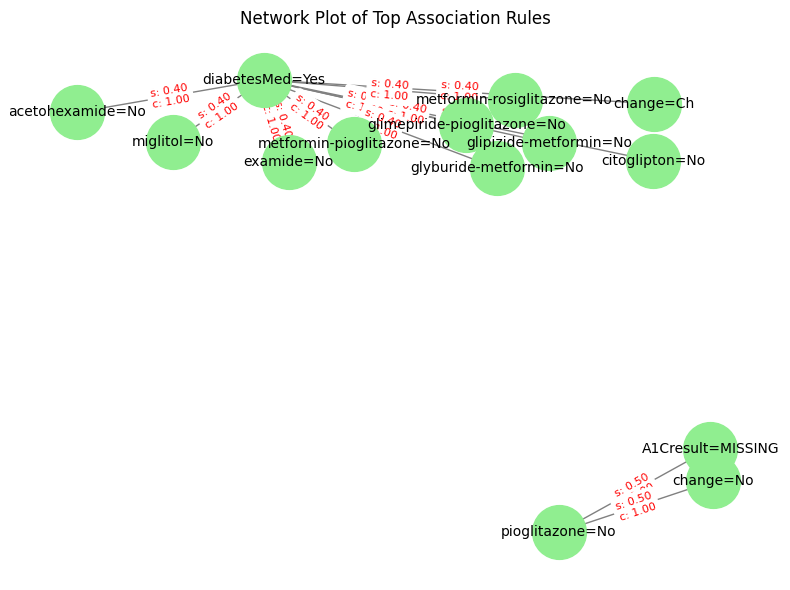

In [46]:
explorer.plot_rules_network(top_n=10, support_threshold=0.2, certainty_threshold=0.990)

## Additional Summaries and Future Directions

### Summary of Findings

- **Rule Discovery:**
  - The pipeline successfully extracts high-confidence association rules that reflect near-deterministic relationships in the data. 
  - Metrics such as support, confidence, lift, conviction, and the derived certainty provide multiple lenses for evaluating rule strength.

- **Data Compliance and Anomaly Detection:**
  - The compliance evaluation process enables a quick check on new data, flagging records that violate learned rules.
  - This can be directly applied to quality assurance in clinical datasets or monitoring systems where rule deviations may signal critical issues.

- **Visual Summaries:**
  - Scatterplots, histograms, bar charts, and parallel coordinate plots aid in understanding the distribution and relationships among the rules.

### Future Directions

- **Refinement of Discretization Methods:**
  - Explore adaptive or data-driven binning techniques to further enhance the quality of discretization for continuous variables.

- **Integration with Advanced Visualization Tools:**
  - Consider incorporating interactive visualization libraries (e.g., Plotly or Bokeh) to allow dynamic exploration of rule metrics.

- **Expansion to Other Data Domains:**
  - While this notebook demonstrates the approach using clinical data, the framework is general and can be extended to other domains such as finance, retail, or IoT sensor data.


This notebook serves as both a demonstration of near-deterministic rule discovery and a starting point for further research and development in anomaly detection systems.